In [1]:
# Following this guide: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.html#Function-transformations-with-Jaxpr

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import Optional
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

## Progress bar
from tqdm.auto import tqdm

In [3]:
b = jnp.arange(6)
b.__class__

jaxlib.xla_extension.ArrayImpl

In [4]:
b.device()

gpu(id=0)

In [5]:
b_cpu = jax.device_get(b)
b_cpu.__class__

numpy.ndarray

In [6]:
# Immutable tensors
b_new = b.at[0].set(1)
print('Original array:', b)
print('Changed array:', b_new)

Original array: [0 1 2 3 4 5]
Changed array: [1 1 2 3 4 5]


In [7]:
def function(x):
  y = x ** 2 + 2 * x
  y = np.sum(y)
  return y

x = jnp.arange(3, dtype=jnp.float32)
grad_func = jax.value_and_grad(function)
grad_func(x)

(Array(11., dtype=float32), Array([2., 4., 6.], dtype=float32))

In [8]:
function(x)

Array(11., dtype=float32)

#Using Flax to solve the XOR problem

In [9]:
try:
  import flax
except: # Install flax if missing
  !pip install --quiet flax
  import flax

from flax import linen as nn

In [10]:
class SimpleClassifier(nn.Module):
  num_hidden : int # Number of hidden neurons
  num_outputs : int # Number of output neurons

  def setup(self):
    """Creates the modules we need to build the network"""

    # nn.Dense is a linear layer
    self.linear1 = nn.Dense(features=self.num_hidden)
    self.linear2 = nn.Dense(features=self.num_outputs)

  def __call__(self, x):
    """Perform the calculation of the model to determine the prediction"""

    x = self.linear1(x)
    x = nn.tanh(x)
    x = self.linear2(x)

    return x

# Simpler version of above
class SimpleClassifierCompact(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        # while defining necessary layers
        x = nn.Dense(features=self.num_hidden)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=self.num_outputs)(x)
        return x

In [11]:
# Creating an instance of the network
model = SimpleClassifierCompact(num_hidden=8, num_outputs=1)
print(model)

SimpleClassifierCompact(
    # attributes
    num_hidden = 8
    num_outputs = 1
)


In [12]:
# Initializing the model
rng = jax.random.PRNGKey(42)
rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.normal(inp_rng, (8, 2)) # Batch size 8 input size 2
rngs = {'params': jax.random.PRNGKey(0), 'bias': jax.random.PRNGKey(1)}
params = model.init(inp_rng, x=inp) # inp calls the x in the '__call__' method
print(params)

FrozenDict({
    params: {
        Dense_0: {
            kernel: Array([[-0.9500004 ,  0.6424682 , -0.21445583, -0.71627176,  1.0488353 ,
                    -0.07033523,  0.08266429,  0.31050897],
                   [ 0.13651964,  0.56213415, -0.6251421 ,  0.29446605,  1.3423129 ,
                     0.14314596, -1.2329347 ,  1.3133264 ]], dtype=float32),
            bias: Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
        },
        Dense_1: {
            kernel: Array([[-0.17866562],
                   [-0.09757274],
                   [ 0.62767947],
                   [ 0.06972209],
                   [-0.11755854],
                   [-0.2936292 ],
                   [-0.0778946 ],
                   [ 0.303467  ]], dtype=float32),
            bias: Array([0.], dtype=float32),
        },
    },
})


In [13]:
model.apply(params, inp) # Calling the model (forward pass through the model)

Array([[-0.05117129],
       [ 0.38055485],
       [-0.13709062],
       [ 0.02018768],
       [-0.01793429],
       [-0.07646844],
       [ 0.03722725],
       [ 0.24985906]], dtype=float32)

In [14]:
# Loading in the data
import torch.utils.data as data

# Just straight up copied this

class XORDataset(data.Dataset):

    def __init__(self, size, seed, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            seed - The seed to use to create the PRNG state with which we want to generate the data points
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.np_rng = np.random.RandomState(seed=seed)
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = self.np_rng.randint(low=0, high=2, size=(self.size, 2)).astype(np.float32)
        label = (data.sum(axis=1) == 1).astype(np.int32)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.np_rng.normal(loc=0.0, scale=self.std, size=data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

dataset = XORDataset(size=200, seed=42)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (array([-0.06800247,  1.0232254 ], dtype=float32), 1)


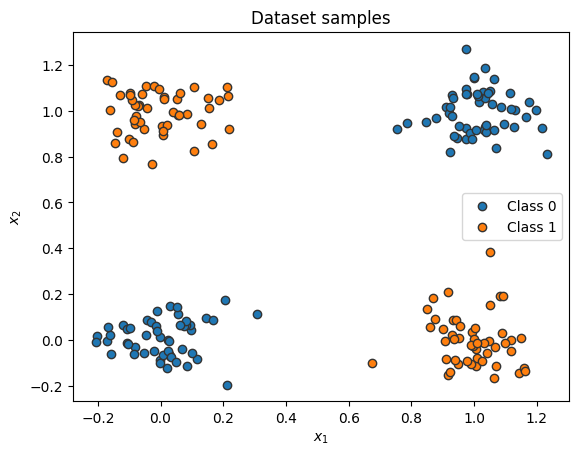

In [15]:
# Visualizing the data
def visualize_samples(data, label):
  data_0 = data[label == 0]
  data_1 = data[label == 1]

  plt.figure()
  plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
  plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
  plt.title("Dataset samples")
  plt.ylabel(r"$x_2$")
  plt.xlabel(r"$x_1$")
  plt.legend()

visualize_samples(dataset.data, dataset.label)
plt.show()

In [16]:
# Using dataloader class of the torch module to set up our input

# Collate function is taken from the JAX tutorial with PyTorch Data Loading
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple, list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=numpy_collate)

In [17]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs (8, 2) 
 [[ 0.14511436  0.09592708]
 [-0.08254972 -0.03213858]
 [ 1.1158111   1.0791663 ]
 [ 0.08254164  0.08135097]
 [ 1.0926178   0.19094166]
 [ 0.95146364  0.00818741]
 [ 1.1266911   0.9292331 ]
 [-0.10060174  0.87858117]]
Data labels (8,) 
 [0 0 0 0 1 1 0 1]


Optimization

In [18]:
# Optax is a Jax compatible module for optimization
try:
  import optax
except ModuleNotFoundError:
  !pip install --quiet optax
  import optax

In [19]:
# Optimizer
# Input to the optimizer settings like learning rate
optimizer = optax.sgd(learning_rate=0.1)

In [20]:
# Bundling important parts of the optimizer using `trainstate`
from flax.training import train_state

# This will always be a state of the model with random initializations
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer,)

In [21]:
def calculate_loss_acc(state, params, batch):
  """
  Function takes in the forward function, parameters, and a batch and returns
  the binary cross entropy loss and the accuracy.
  """
  data_input, labels = batch

  # Obtain logits and predictions of the model for the input data
  logits = state.apply_fn(params, data_input).squeeze(axis=1)
  pred_labels = (logits > 0).astype(jnp.float32)

  # Calculate the loss and accuracy
  loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
  acc = (pred_labels == labels).mean()

  return loss, acc

# example
batch = next(iter(data_loader))
calculate_loss_acc(model_state, model_state.params, batch)

(Array(0.7020761, dtype=float32), Array(0.375, dtype=float32))

In [22]:
@jax.jit
def train_step(state, batch):
  """
  Making a training step for the model
  """
  grad_fn = jax.value_and_grad(calculate_loss_acc, # Function to calculate the loss
                               argnums=1, # Parameters are second argument of the function
                               has_aux=True) # Function has additional outputs (acc)

  # Determine gradients for current model, parameters and batch
  (loss, acc), grads = grad_fn(state, state.params, batch)

  # Perform parameter update with gradients and optimizer
  state = state.apply_gradients(grads=grads)

  # Return state and any other value that we might want
  return state, loss, acc

In [23]:
@jax.jit
def eval_step(state, batch):
  """
  evaluation of the model for accutracy
  """
  _, acc = calculate_loss_acc(state, state.params, batch)
  return acc

Training

In [24]:
# creating a larger dataset with a larger batch size
train_dataset = XORDataset(size=2500, seed=42)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=numpy_collate)

In [25]:
def train_model(state, data_loader, num_epochs=100):
  """
  Trains the model for several epochs
  """
  # Training loop
  for epoch in tqdm(range(num_epochs)):
    for batch in data_loader:
      state, loss, acc = train_step(state, batch)
      # THIS is where you would log the accuracy and the loss

  return state

In [26]:
trained_model_state = train_model(model_state, train_data_loader, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
calculate_loss_acc(trained_model_state, trained_model_state.params, batch) # checking the loss and acc

(Array(0.03970754, dtype=float32), Array(1., dtype=float32))

Saving the model

In [28]:
from flax.training import checkpoints

# Saving the state
checkpoints.save_checkpoint(ckpt_dir='my_checkpoints/',  # Folder to save checkpoint in
                            target=trained_model_state,  # What to save. To only save parameters, use model_state.params
                            step=100,  # Training step or other metric to save best model on
                            prefix='my_model',  # Checkpoint file name prefix
                            overwrite=True   # Overwrite existing checkpoint files
                           )

'my_checkpoints/my_model100'

In [29]:
# Loading the state
loaded_model_state = checkpoints.restore_checkpoint(
                                             ckpt_dir='my_checkpoints/',   # Folder with the checkpoints
                                             target=model_state,   # (optional) matching object to rebuild state in
                                             prefix='my_model'  # Checkpoint file name prefix
                                            )

Evaluation

In [30]:
# Creating a test set
test_dataset = XORDataset(size=500, seed=2)
test_data_loader = data.DataLoader(test_dataset,
                                   batch_size=128,
                                   shuffle=False,
                                   drop_last=False, # Don't drop the last even though <128
                                   collate_fn=numpy_collate,)

In [31]:
def eval_model(state, data_loader):
  """
  evaluates the accuracy of the model on test data
  """
  all_accs, batch_sizes = [], []

  for batch in data_loader:
    batch_acc = eval_step(state, batch)
    all_accs.append(batch_acc)
    batch_sizes.append(batch[0].shape[0])

  # calculate weighted average since some batches smaller than others
  acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)

  print(f"Accuracy of the model: {100.0*acc:3.2f}%")

eval_model(trained_model_state, test_data_loader)

Accuracy of the model: 100.00%


Binding model parameters

In [39]:
# Gives a way to test the model a lot of times without doing `model.apply()` all the time
trained_model = model.bind(trained_model_state.params)
data_input, labels = next(iter(data_loader))
out = trained_model(data_input)  # No explicit parameter passing necessary anymore
out, labels

TypeError: ignored

In [35]:
activations

NameError: ignored

Visualizing the model

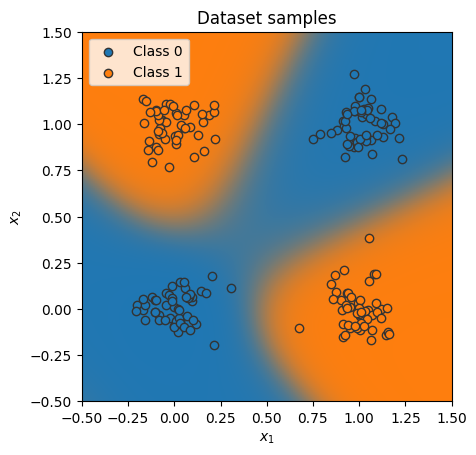

In [33]:
def visualize_classification(model, data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure()
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    c0 = np.array(to_rgba("C0"))
    c1 = np.array(to_rgba("C1"))
    x1 = jnp.arange(-0.5, 1.5, step=0.01)
    x2 = jnp.arange(-0.5, 1.5, step=0.01)
    xx1, xx2 = jnp.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = np.stack([xx1, xx2], axis=-1)
    logits = model(model_inputs)
    preds = nn.sigmoid(logits)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = jax.device_get(output_image)  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(trained_model, dataset.data, dataset.label)
plt.show()

Notes - <i>sharp bits</i>


*   Need to potentially pad the model if creating a graph structure
*   Potentially need to un-jit functions to debug



In [34]:
parameters = jax.tree_util.tree_leaves(trained_model_state.params)
parameters

[Array([-0.06472857, -0.15901586, -0.3413977 , -0.5444363 , -0.7205891 ,
        -0.63075244, -0.31131357, -0.49723634], dtype=float32),
 Array([[-2.2031221 ,  0.5939691 ,  1.3909935 , -2.7789044 ,  2.5217512 ,
          0.354001  ,  1.3840061 ,  2.1854289 ],
        [ 0.96469885,  0.49375477, -2.5101526 ,  1.7474917 ,  2.571648  ,
          0.6082995 , -2.5616095 ,  2.2819786 ]], dtype=float32),
 Array([0.11344428], dtype=float32),
 Array([[ 2.1731164 ],
        [-0.23660639],
        [ 2.7750852 ],
        [ 3.2803273 ],
        [ 3.2498422 ],
        [-1.0869635 ],
        [ 2.6223688 ],
        [ 2.6982427 ]], dtype=float32)]